In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Target will be logged and values of Yield lower than 0.2 will be dropped compared to model 1

# Exploration and Cleaning

In [4]:
# df.info()
# df['Yield'].plot()

In [5]:

# pd.set_option('display.float_format', '{:.4f}'.format)
# df.describe(percentiles=[.25,.5,.75,.98])

In [6]:
# corr = df.corr(numeric_only=True)
# plt.figure(figsize=(10, 8))  # Adjust the figure size as per your preference
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Matrix')
# plt.show()


In [2]:
def cleaning():
    df = pd.read_csv('crop_yield.csv', header=0, index_col='ID')
    df.drop(columns=['Crop_Year', 'Production'], inplace=True)
    df = df[(df['Yield'] > 0.2) & (df['Yield'] <= 50)]
    df = df[df["Crop"] != 'Coconut']
    return df

# Split Test_Train

In [3]:
from sklearn.model_selection import train_test_split

df = cleaning()

print(df.shape)

# Define the feature matrix and target variable
X = df.drop('Yield', axis=1)
y = df['Yield']

# Stratified split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['Crop'], random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

(18544, 8)


((14835, 7), (3709, 7), (14835,), (3709,))

# Further Exploration and Feature Engineering

In [9]:
# X_train.hist(bins = 100, figsize=(12, 8))

In [10]:
# X.corr(numeric_only=True)

In [11]:
# from pandas.plotting import scatter_matrix

# a = ['Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']

# scatter_matrix(X[a], figsize=(12, 8))

# Processing X_train

In [4]:
# Necessary imports
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.utils.validation import check_is_fitted


# Custom transformer for frequency encoding
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_dict_ = {}

    def fit(self, X, y=None):
        # Compute the frequency of each category in each column
        X_df = pd.DataFrame(X, columns=["Crop", "State"])  # Convert numpy array to DataFrame
        self.freq_dict_ = {col: X_df[col].value_counts(normalize=True).to_dict() for col in X_df.columns}
        return self

    def transform(self, X, y=None):
        check_is_fitted(self)
        X_transformed = pd.DataFrame(X, columns=["Crop", "State"]).copy()  # Convert numpy array to DataFrame
        # Replace each category with its frequency
        for col in X_transformed.columns:
            X_transformed[col] = X_transformed[col].map(self.freq_dict_[col])
        return X_transformed.values  # Return numpy array

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_constant=1e-10):
        self.add_constant = add_constant

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = np.log(X + self.add_constant)
        return X_transformed

# Update column_ratio function to handle DataFrame inputs
def column_ratio(df):
    return (df.iloc[:, 0] / df.iloc[:, 1]).values.reshape(-1, 1)

# Create a pipeline for calculating the ratio
ratio_pipeline = make_pipeline(FunctionTransformer(column_ratio, validate=False), StandardScaler())

# Create a pipeline for logarithm transformation and scaling
log_pipeline = make_pipeline(LogTransformer(), StandardScaler())


# Pipelines for frequency encoding and one hot encoding
freq_enc_pipeline = Pipeline(steps=[('freq_enc', FrequencyEncoder())])
one_hot_enc_pipeline = Pipeline(steps=[('one_hot_enc', OneHotEncoder(sparse_output=False))])


# Update the preprocessing pipeline with the correct pipeline names
preprocessing = ColumnTransformer([
    ("Pesticide_per_hectar", ratio_pipeline, ["Pesticide", "Area"]),
    ("Fertilizer_per_hectar", ratio_pipeline, ["Fertilizer","Area"]),
    ("log", log_pipeline, make_column_selector(dtype_exclude=object)),
    ("freq_enc", freq_enc_pipeline, ["Crop", "State"]),
    ("one_hot_enc", one_hot_enc_pipeline, ["Season"])
])

# Fit the transformer to the training data
preprocessing.fit(X_train)

# Get the feature names from the transformers
transformed_feature_names = (
    ["Log_Pesticide_per_hectar", "Log_Fertilizer_per_hectar"]  # Ratio columns
    + [f"log_{feature}" for feature in make_column_selector(dtype_exclude=object)(X_train)]  # Log columns
    + ["freq_enc_Crop", "freq_enc_State"]  # Frequency encoded columns
    + list(preprocessing.named_transformers_["one_hot_enc"].named_steps["one_hot_enc"].get_feature_names_out(input_features=["Season"]))  # One hot encoded columns
)

# Transform the training data
data_transformed = preprocessing.transform(X_train)
# Create a DataFrame from the transformed training data
data_transformed_df = pd.DataFrame(data_transformed, columns=transformed_feature_names, index=X_train.index)

# Display the first few rows of the transformed DataFrame
data_transformed_df.head()


,Log_Pesticide_per_hectar,Log_Fertilizer_per_hectar,log_Area,log_Annual_Rainfall,log_Fertilizer,log_Pesticide,freq_enc_Crop,freq_enc_State,Season_Autumn,Season_Kharif,Season_Rabi,Season_Summer,Season_Whole Year,Season_Winter
ID,,,,,,,,,,,,,,
13030,0.484995,0.518049,-0.703754,0.418683,-0.668757,-0.646738,0.025480,0.055612,1.0,0.0,0.0,0.0,0.0,0.0
18457,-0.062468,-1.190459,-0.229613,0.995074,-0.310813,-0.219643,0.052444,0.021638,0.0,1.0,0.0,0.0,0.0,0.0
13135,-0.062468,0.276708,-0.105899,-0.460119,-0.082421,-0.096122,0.022582,0.040512,0.0,0.0,0.0,0.0,1.0,0.0
9841,-0.746797,-0.365082,0.363916,-0.334223,0.348032,0.304318,0.018739,0.043748,0.0,1.0,0.0,0.0,0.0,0.0
9821,-0.746797,-0.365082,0.745287,-0.098975,0.731252,0.685092,0.064442,0.032558,0.0,1.0,0.0,0.0,0.0,0.0


# Model

In [13]:
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import mean_squared_error, r2_score 

# lin_reg = make_pipeline(preprocessing, LinearRegression())

# lin_reg.fit(X_train, y_train)

# predictions = lin_reg.predict(X_train)

# lin_rmse = mean_squared_error(y_train, predictions, squared=False)

# r2 = r2_score(y_train, predictions)

# # Calculate adjusted R^2
# n = len(y_train)  # Number of observations
# p = X_train.shape[1]  # Number of predictors

# adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


# lin_rmse, r2


In [14]:
# from sklearn.tree import DecisionTreeRegressor

# Tree = make_pipeline(preprocessing, DecisionTreeRegressor())

# Tree.fit(X_train, y_train)

# prediction = Tree.predict(X_train)

# lin_rmse = mean_squared_error(y_train, prediction, squared=False)

# r2 = r2_score(y_train, prediction)

# # Calculate adjusted R^2
# n = len(y_train)  # Number of observations
# p = X_train.shape[1]  # Number of predictors

# adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


# lin_rmse, r2



In [15]:
# from sklearn.ensemble import RandomForestRegressor, VotingRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
# from sklearn.neighbors import KNeighborsRegressor

# rand_forest = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

# K_naib = make_pipeline(preprocessing, KNeighborsRegressor(n_neighbors=15))

# Gradient_boos_hist = make_pipeline(preprocessing, HistGradientBoostingRegressor(random_state=42))

# Gradient_boost_normal = make_pipeline(preprocessing, GradientBoostingRegressor(random_state=42))


# Cross-val predictions testing

In [16]:
# from sklearn.model_selection import cross_val_score

# Rmse = -cross_val_score(rand_forest, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)

# pd.Series(Rmse).describe()

# GridSearch

In [17]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# full_pipeline = Pipeline([("preprocessing", preprocessing), ("random_forest", RandomForestRegressor(random_state=42))])

# param_grid = {
#     'random_forest__n_estimators': [400],
#     'random_forest__max_features': ['log2', 'sqrt', 1],
#     'random_forest__max_depth': [None],
#     'random_forest__min_samples_split': [2],
#     'random_forest__min_samples_leaf': [1],
#     'random_forest__bootstrap': [True]
# }

# grid_search = GridSearchCV(full_pipeline, param_grid=param_grid, cv = 5, scoring='neg_root_mean_squared_error', n_jobs=-1,verbose=2)

# grid_search.fit(X_train, y_train)

# final_model = grid_search.best_estimator_


# RandSearch

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

full_pipeline = Pipeline([("preprocessing", preprocessing), ("random_forest", RandomForestRegressor(random_state=42))])


param_dist = {
    'random_forest__n_estimators': randint(low=100, high=400),
    'random_forest__max_features': [1.0 , 'sqrt', 'log2'],
    'random_forest__max_depth': [10, 50, 100, None],
    'random_forest__min_samples_split': randint(low=2, high=10),
    'random_forest__min_samples_leaf': randint(low=1, high=3),
    'random_forest__bootstrap': [True, False]
}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_root_mean_squared_error', random_state=1, n_jobs=-1, verbose=2)

y_train_log = np.log1p(y_train)

rnd_search.fit(X_train, y_train_log)

final_model_2 = rnd_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END random_forest__bootstrap=False, random_forest__max_depth=10, random_forest__max_features=log2, random_forest__min_samples_leaf=2, random_forest__min_samples_split=4, random_forest__n_estimators=376; total time=   3.7s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=10, random_forest__max_features=log2, random_forest__min_samples_leaf=2, random_forest__min_samples_split=4, random_forest__n_estimators=376; total time=   3.7s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=10, random_forest__max_features=log2, random_forest__min_samples_leaf=2, random_forest__min_samples_split=4, random_forest__n_estimators=376; total time=   3.8s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=50, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5, random_forest__n_estimators=352; total time=   3.8s
[CV] END random_forest__bootstr

/opt/homebrew/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END random_forest__bootstrap=False, random_forest__max_depth=100, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2, random_forest__n_estimators=298; total time=   5.8s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=100, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2, random_forest__n_estimators=298; total time=   6.0s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=None, random_forest__max_features=1.0, random_forest__min_samples_leaf=1, random_forest__min_samples_split=9, random_forest__n_estimators=270; total time=  11.3s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=100, random_forest__max_features=1.0, random_forest__min_samples_leaf=2, random_forest__min_samples_split=4, random_forest__n_estimators=379; total time=  15.5s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=100, random_forest__max_fe

In [20]:
feature_importance = final_model_2["random_forest"].feature_importances_

feature_importance.round(2)

rnd_search.best_params_, feature_importance

({'random_forest__bootstrap': True,
  'random_forest__max_depth': None,
  'random_forest__max_features': 1.0,
  'random_forest__min_samples_leaf': 1,
  'random_forest__min_samples_split': 2,
  'random_forest__n_estimators': 353},
 array([1.06374833e-02, 1.97819420e-02, 4.85077839e-02, 4.52631673e-02,
        4.10449923e-02, 3.24923037e-02, 5.70198669e-01, 8.11610003e-02,
        6.09563739e-04, 3.50438984e-03, 6.99417847e-03, 5.98090653e-03,
        1.33561410e-01, 2.62209629e-04]))

In [ ]:
# from sklearn.model_selection import cross_val_score

# Rmse = -cross_val_score(final_model_2, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

# pd.Series(Rmse).describe()

# Testing the model

In [21]:
from sklearn.metrics import mean_squared_error

final_pred_log = final_model_2.predict(X_test)

final_pred = np.expm1(final_pred_log)

final_rmse = mean_squared_error(y_test, final_pred, squared=False)

final_rmse
# Result : 2.146



2.156247752607154

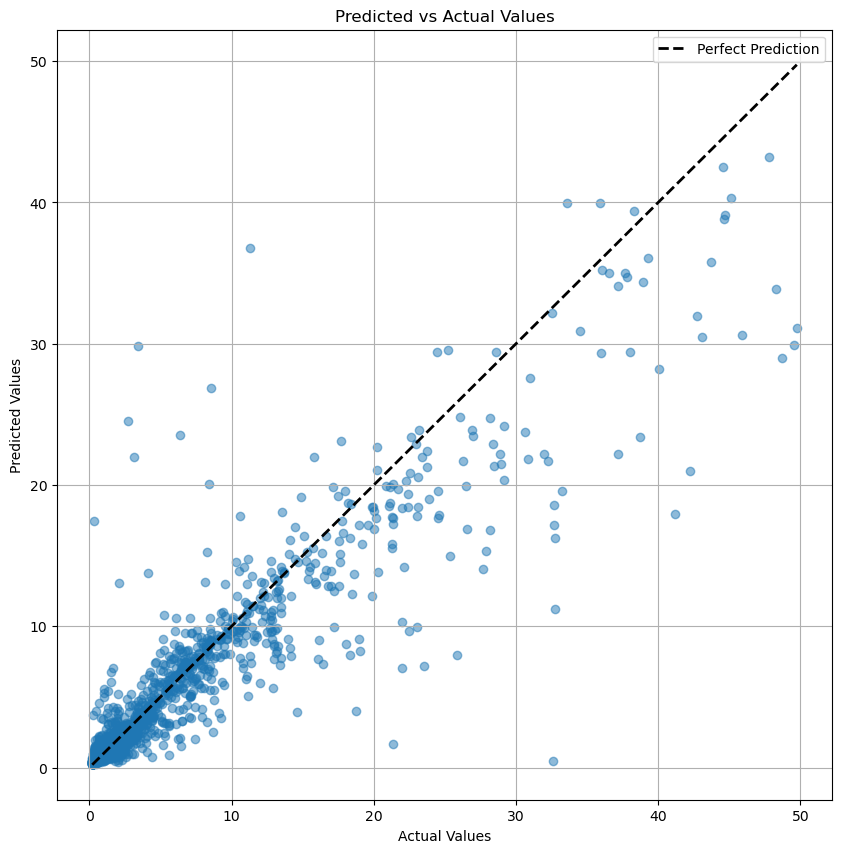

In [23]:


# Convert numpy arrays to pandas Series
final_pred_series = pd.Series(final_pred, name="Predicted", index=y_test.index)
y_test_series = pd.Series(y_test, name="Actual")

# Create a new figure for the scatter plot of the predictions
plt.figure(figsize=(10, 10))
plt.scatter(y_test_series, final_pred_series, alpha=0.5)
plt.plot([y_test_series.min(), y_test_series.max()], [y_test_series.min(), y_test_series.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
import joblib

joblib.dump(final_model_2, "Model_vesrion_2_Log.pkl")

['Model_vesrion_2_Log.pkl']